In [1]:
#Set-up
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings 
from sklearn.model_selection import train_test_split
import pandas as pd 
from tensorflow.keras import layers, models
warnings.filterwarnings(action='ignore')

In [ ]:
목차  1.cnn 모델구현하기
      2. 데이터 augmentation을 사용해 베이스 모델과의 성능비교
      3. resnet모델을 구현하고 학습시키기

In [2]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*' # *은 모든 디렉토리와 파일을 의미합니다.
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'


BATCH_SIZE = 16
EPOCHS = 10

print(ROOT_PATH)

/aiffel/aiffel


In [3]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH)   #각 데이터들의 개수확인
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


In [4]:
# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


In [5]:
print(f'Normal image path\n{filenames[0]}')        # 정상이미지와 폐렴이미지 경로
print(f'Pneumonia image path\n{filenames[2000]}')

Normal image path
/aiffel/aiffel/chest_xray/data/train/NORMAL/IM-0450-0001.jpeg
Pneumonia image path
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person1345_bacteria_3422.jpeg


In [6]:
#정상이미지 폐렴이미지 세기
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")


COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1070
Pneumonia images count in training set: 3115


In [7]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)    #tf.data 인스턴스 만들기
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [8]:
#데이터셋 개수 확인
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


In [9]:
# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

In [10]:
# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

In [11]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)   #train 데이터 셋과 validation 데이터 셋을만들기
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [12]:
for image, label in train_ds.take(1):            #이미지가 잘 리사이즈 되었는지, 그리고 라벨이 잘 들어가 있는지 확인
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  False


In [13]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)#test 데이터셋도 만들기. 그리고 데이터 개수도 확인
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


In [14]:
def prepare_for_training(ds, shuffle_buffer_size=1000): #prefetch를 사용하여 리소스 유휴상태줄이기
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

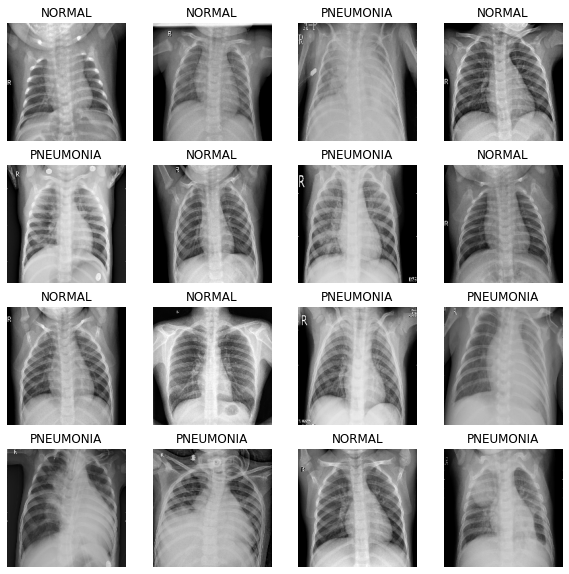

In [15]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4,math.ceil(BATCH_SIZE/4),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

In [19]:
#convolution block 만들기
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

In [20]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [21]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

In [22]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0   #데이터 불균형 처리
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.96
Weight for PNEUMONIA: 0.67


In [23]:
with tf.device('/GPU:0'):         #모델훈련
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [21]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/10
261/261 [==============================] - 84s 209ms/step - loss: 0.3629 - accuracy: 0.8161 - precision: 0.9570 - recall: 0.7884 - val_loss: 0.7567 - val_accuracy: 0.7337 - val_precision: 0.7337 - val_recall: 1.0000
Epoch 2/10
261/261 [==============================] - 54s 206ms/step - loss: 0.2386 - accuracy: 0.9057 - precision: 0.9738 - recall: 0.8974 - val_loss: 1.3112 - val_accuracy: 0.7327 - val_precision: 0.7327 - val_recall: 1.0000
Epoch 3/10
261/261 [==============================] - 53s 205ms/step - loss: 0.1896 - accuracy: 0.9315 - precision: 0.9770 - recall: 0.9298 - val_loss: 0.4970 - val_accuracy: 0.7913 - val_precision: 0.7788 - val_recall: 1.0000
Epoch 4/10
261/261 [==============================] - 54s 209ms/step - loss: 0.1668 - accuracy: 0.9406 - precision: 0.9837 - recall: 0.9355 - val_loss: 0.1402 - val_accuracy: 0.9413 - val_precision: 0.9279 - val_recall: 0.9974
Epoch 5/10
261/261 [==============================] - 55s 211ms/step - loss: 0.1605 - accura

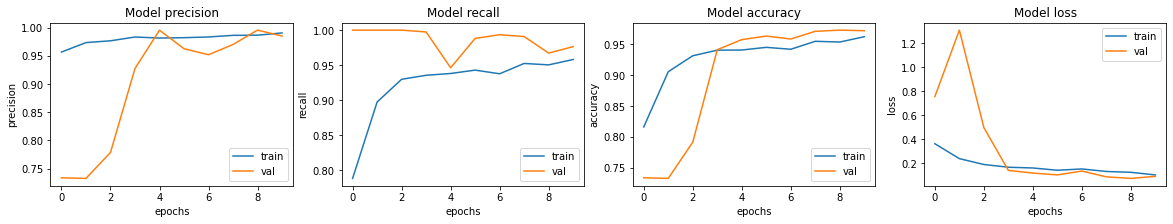

In [22]:
#결과 확인하기
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [23]:
# 모델 평가를 위해 loss, accuracy, precision, recall 값을 출력
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 4s 105ms/step - loss: 0.7971 - accuracy: 0.7628 - precision: 0.7292 - recall: 0.9872
Loss: 0.797122061252594,
Accuracy: 0.7628205418586731,
Precision: 0.7291666865348816,
Recall: 0.9871794581413269


In [14]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
    
    return image,label
# augmentation 수행
def prepare_for_training(ds, shuffle_buffer_size=1000):
    
    # augment 적용 부분이 배치처리 함수에 추가되었습니다.
    ds = ds.map(
            augment,                 # augment 함수 적용
            num_parallel_calls=2
        )

    ds = ds.shuffle(buffer_size=shuffle_buffer_size)  # 해당 버퍼에서 무작위로 균일하게 다음 요소를 선택

    ds = ds.repeat()            # epoch를 진행하면서 여러번 데이터셋을 불러오기

    ds = ds.batch(BATCH_SIZE)   # BATCH_SIZE 만큼 배치로 전달

    ds = ds.prefetch(buffer_size=AUTOTUNE)   # GPU에서 학습하는 동안 다음 데이터를 CPU에서 준비

    return ds

In [15]:
# 데이터를 증식시킨 데이터 셋 생성
train_ds = train_ds.map(augment, num_parallel_calls=AUTOTUNE)
train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

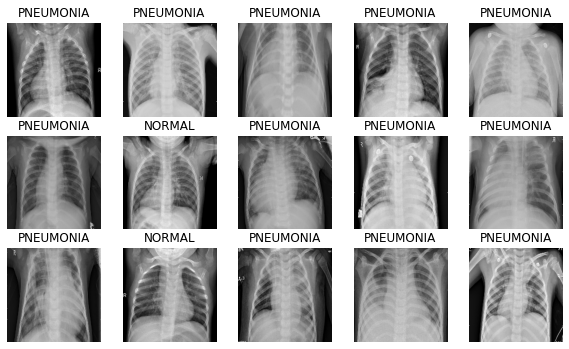

In [17]:
image_batch, label_batch = next(iter(train_ds))

def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(15):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")

show_batch(image_batch.numpy(), label_batch.numpy())

In [25]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/10
261/261 [==============================] - 64s 205ms/step - loss: 0.1537 - accuracy: 0.9409 - precision: 0.9815 - recall: 0.9382 - val_loss: 0.0887 - val_accuracy: 0.9683 - val_precision: 0.9802 - val_recall: 0.9764
Epoch 2/10
261/261 [==============================] - 53s 205ms/step - loss: 0.1535 - accuracy: 0.9442 - precision: 0.9812 - recall: 0.9430 - val_loss: 0.0985 - val_accuracy: 0.9663 - val_precision: 0.9840 - val_recall: 0.9699
Epoch 3/10
261/261 [==============================] - 53s 204ms/step - loss: 0.1490 - accuracy: 0.9466 - precision: 0.9842 - recall: 0.9434 - val_loss: 0.1212 - val_accuracy: 0.9462 - val_precision: 0.9972 - val_recall: 0.9290
Epoch 4/10
261/261 [==============================] - 53s 205ms/step - loss: 0.1352 - accuracy: 0.9480 - precision: 0.9875 - recall: 0.9421 - val_loss: 0.0745 - val_accuracy: 0.9712 - val_precision: 0.9804 - val_recall: 0.9804
Epoch 5/10
261/261 [==============================] - 54s 207ms/step - loss: 0.1413 - accura

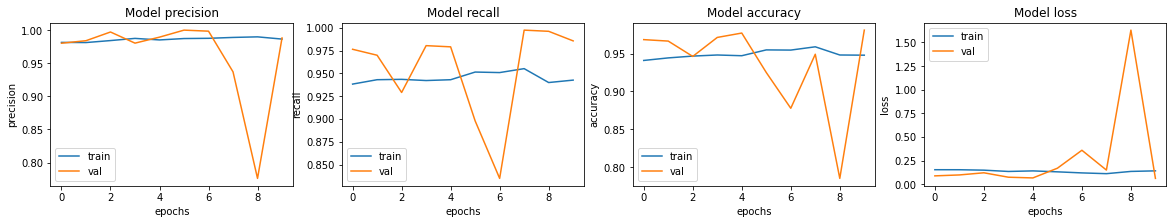

In [27]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [ ]:
## 데이터 증식후 validation 데이터에 대한 성능은 악화되었고   precision과 recall이 큰 변동을 보임 그러므로 증식전데이터가 더 좋다생각한다

In [ ]:
##Resnet 모델 구현하기

In [28]:
# Residual 블록 구성하기
def residual_block(x, filters, kernel_size=3, stride=1):
    shortcut = x
    
    # First convolution layer
    x = layers.Conv2D(filters, kernel_size=kernel_size, strides=stride, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    
    # Second convolution layer
    x = layers.Conv2D(filters, kernel_size=kernel_size, strides=1, padding='same')(x)
    x = layers.BatchNormalization()(x)
    
    # Add shortcut (residual connection)
    if stride != 1 or shortcut.shape[-1] != filters:
        shortcut = layers.Conv2D(filters, kernel_size=1, strides=stride)(shortcut)
    
    x = layers.add([x, shortcut])
    x = layers.ReLU()(x)
    
    return x

In [29]:
# ResNet-18 모델 구현
def ResNet18(input_shape=(224, 224, 3), num_classes=1000):
    inputs = layers.Input(shape=input_shape)

    # Initial conv and max pool
    x = layers.Conv2D(64, (7, 7), strides=2, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D((3, 3), strides=2, padding='same')(x)
    
    # Conv2_x
    x = residual_block(x, 64)
    x = residual_block(x, 64)
    
    # Conv3_x
    x = residual_block(x, 128, stride=2)
    x = residual_block(x, 128)
    
    # Conv4_x
    x = residual_block(x, 256, stride=2)
    x = residual_block(x, 256)
    
    # Conv5_x
    x = residual_block(x, 512, stride=2)
    x = residual_block(x, 512)
    
    # Average Pool and Fully Connected Layer
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(num_classes, activation='softmax')(x)
    
    model = models.Model(inputs, x)
    return model

In [30]:
# Create the ResNet18모델
model = ResNet18(input_shape=(224, 224, 3), num_classes=1000)

# 컴파일하기
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 112, 112, 64) 9472        input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_7 (BatchNor (None, 112, 112, 64) 256         conv2d_2[0][0]                   
__________________________________________________________________________________________________
re_lu (ReLU)                    (None, 112, 112, 64) 0           batch_normalization_7[0][0]      
______________________________________________________________________________________________

In [33]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0     #클래스 불균형 처리
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.96
Weight for PNEUMONIA: 0.67


In [34]:
with tf.device('/GPU:0'):     #모델훈련
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [35]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/10
261/261 [==============================] - 63s 207ms/step - loss: 0.4613 - accuracy: 0.7584 - precision: 0.9371 - recall: 0.7239 - val_loss: 0.5777 - val_accuracy: 0.7356 - val_precision: 0.7356 - val_recall: 1.0000
Epoch 2/10
261/261 [==============================] - 53s 205ms/step - loss: 0.2406 - accuracy: 0.9102 - precision: 0.9783 - recall: 0.8994 - val_loss: 0.9094 - val_accuracy: 0.7337 - val_precision: 0.7337 - val_recall: 1.0000
Epoch 3/10
261/261 [==============================] - 53s 202ms/step - loss: 0.2351 - accuracy: 0.9116 - precision: 0.9704 - recall: 0.9089 - val_loss: 0.2734 - val_accuracy: 0.8596 - val_precision: 0.8394 - val_recall: 1.0000
Epoch 4/10
261/261 [==============================] - 54s 205ms/step - loss: 0.1857 - accuracy: 0.9253 - precision: 0.9781 - recall: 0.9203 - val_loss: 0.1787 - val_accuracy: 0.9308 - val_precision: 0.9148 - val_recall: 0.9987
Epoch 5/10
261/261 [==============================] - 54s 209ms/step - loss: 0.2033 - accura

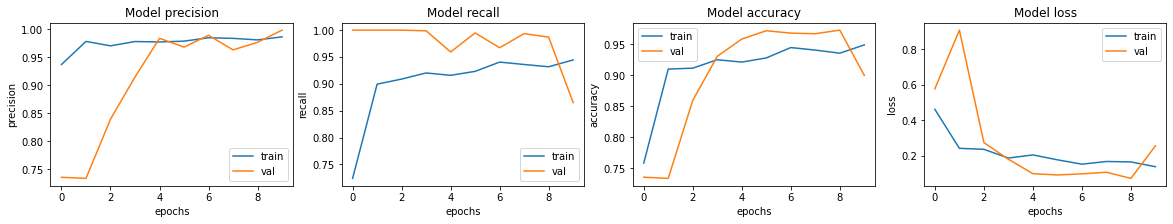

In [36]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))   #결과확인
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [37]:
loss, accuracy, precision, recall = model.evaluate(test_ds)    #모델 평가
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 5s 121ms/step - loss: 0.4168 - accuracy: 0.8670 - precision: 0.8735 - recall: 0.9205
Loss: 0.4168115258216858,
Accuracy: 0.8669871687889099,
Precision: 0.8734793066978455,
Recall: 0.9205127954483032


In [ ]:
## 데이터 augmentation하고 시각화하는게 잘 안되서 해결하느라 시간을 많이써서 구조변경을 통한 성능비교를 못했다